# Advanced Lane Finding
## Udacity Self-Driving Car Nanodegree

### By Ethan Peacock
---

### Overview

The goal of this project is to write a software pipeline to indentify the lane
boundaries in a video with a front-facing camera on a car.  The camera<br>
calibration images, test road images, and project videos are available<br>
in this project repository:  https://github.com/udacity/CarND-Advanced-Lane-Lines

<br>
Below is a summary of the techniques used in this project.

1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
5. Detect lane lines
6. Determine the lane curvature

---

In [7]:
# Imports
import pickle
import glob
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
# %matplotlib notebook  #  Enables interactive windows in jupyter notebook

# Undistort Function

In [8]:
# performs the camera calibration, image distortion correction and 
# returns the undistorted image        

# Read in each image
img = mpimg.imread('camera_cal/calibration1.jpg')
# Convert image to grayscale to use for gray.shape to get image dimensions
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

# Compute the camera calibration matrix and distortion coefficients

In [9]:
#  Define name of a picle file
pickle_file = "wide_dist_pickle.p"
# Read in and make a list of calibration images
images = glob.glob('./camera_cal/*')


# If a pickel file exists, then load the file
if os.path.isfile(pickle_file):
    print("A pickle file exists")
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        mtx = pickle_data['mtx']
        dist = pickle_data['dist']
        objpoints = pickle_data['objpoints']
        imgpoints = pickle_data['imgpoints']

        del pickle_data  # Free up memory
# If not found, start calibrating using example images
else:
    # Arrays to store object points and image points from all the imgaes
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ...., (7,5,0)
    nx = 9 # Number of inside corners of x
    ny = 6 # Number of inside corners of y

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:6].T.reshape(-1,2) # x, y coordinates

    for fname in images:
        # Read in each image
        img = mpimg.imread(fname)
        # Convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)


        # If corners are found, add object points, image points
        if ret == True:
            print(fname)
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            plt.imshow(img)
            plt.savefig('output_images/draw_corners/' + str(fname))
            plt.savefig('output_images/cornersDrawnOn.jpg')

    distorted_img = mpimg.imread('camera_cal/calibration1.jpg')
    # create mtx and dist from cal_undistort function
    dst, mtx, dist = cal_undistort(distorted_img, objpoints, imgpoints)
    
    # Visualize
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(distorted_img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Save camera calibration result for later use in pickle file    
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    dist_pickle['objpoints'] = objpoints
    dist_pickle['imgpoints'] = imgpoints
    pickle.dump(dist_pickle, open(pickle_file, 'wb'))

A pickle file exists


# Combine Color and gradient thresholds for lane detection

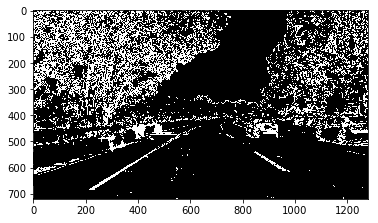

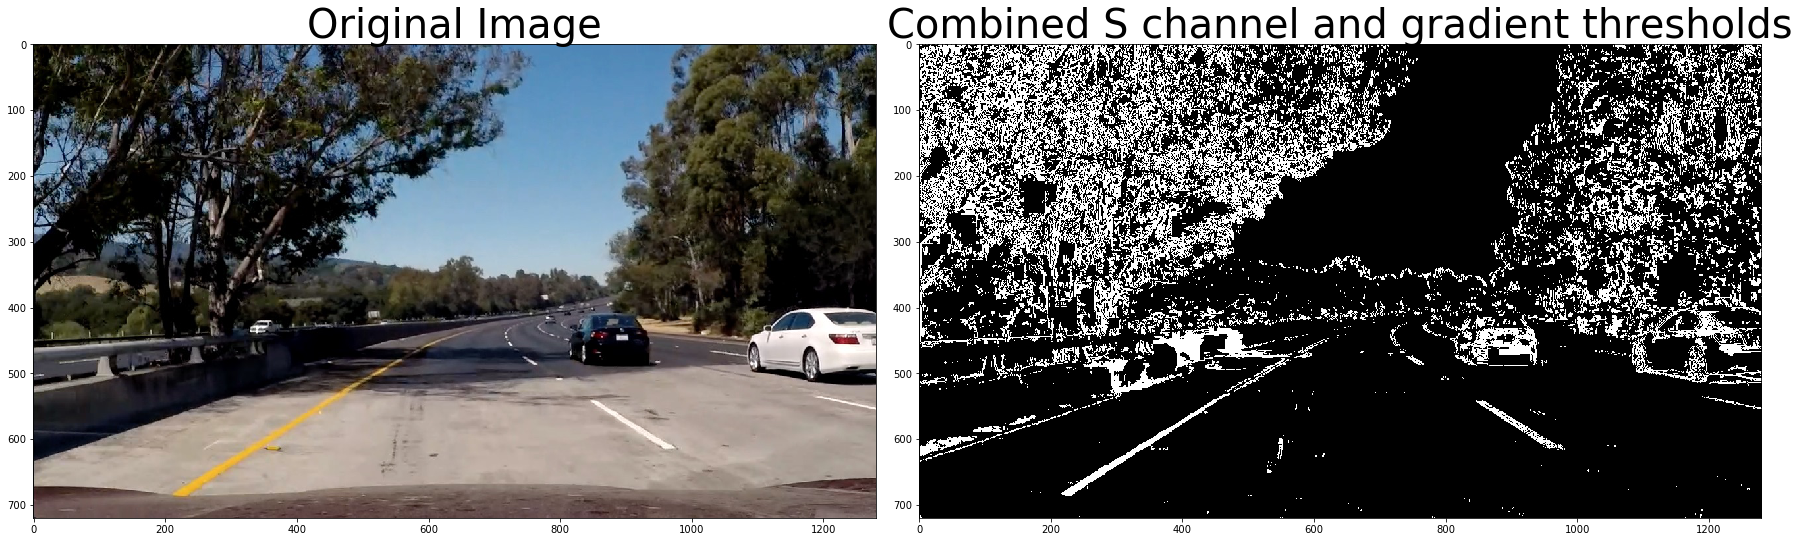

In [10]:
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)

    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] =1
    return combined_binary


# Visualize with test
thresh_test_image = mpimg.imread('test_images/test5.jpg')
thresh_result_test = threshold(thresh_test_image)
plt.imshow(thresh_result_test, cmap = plt.get_cmap('gray'))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(thresh_test_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(thresh_result_test, cmap = plt.get_cmap('gray'))
ax2.set_title('Combined S channel and gradient thresholds', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/combined_binary.jpg')

# Perspective Transform

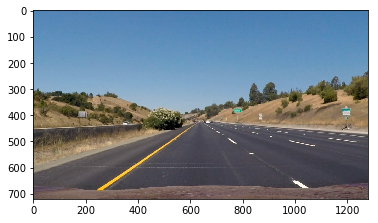

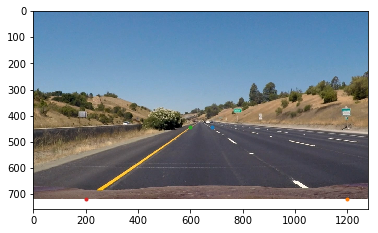

In [11]:
#read in and display original image
perspective_transform_img = mpimg.imread('test_images/straight_lines1.jpg')
plt.imshow(perspective_transform_img)
plt.show()

# Source image points
imshape = perspective_transform_img.shape
plt.imshow(perspective_transform_img)
plt.plot(681, 444, '.') # top right
plt.plot(1200, imshape[0], '.') # bottom right
plt.plot(598, 444, '.') # top left
plt.plot(200, imshape[0], '.') # bottom left

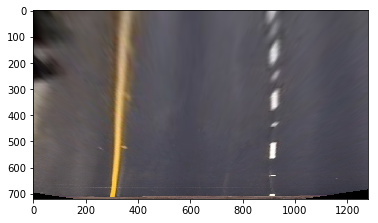

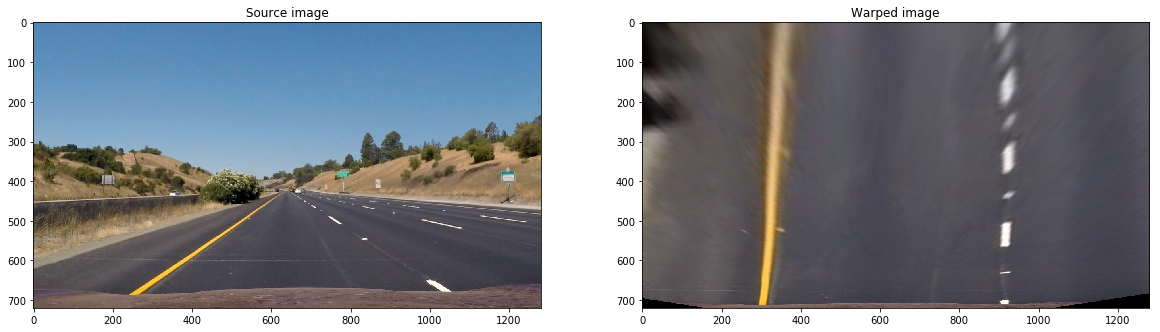

In [12]:
# Define perspective transform function

# Four source coordinates
src = np.float32(
    [[681, 444],
     [1200, imshape[0]],
     [598, 444],
     [200, imshape[0]]])

# Four desired coordinates
dst = np.float32(
    [[975, (imshape[0] - imshape[0])],
     [975, imshape[0]],
     [300, (imshape[0] - imshape[0])],
     [300, imshape[0]]])

def warp(img):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the perspective transform inverse, Minv
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped


# Visualize with test
warped_im_test = warp(perspective_transform_img)
plt.imshow(warped_im_test)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.set_title('Source image')
ax1.imshow(perspective_transform_img)
ax2.set_title('Warped image')
ax2.imshow(warped_im_test)
plt.savefig('output_images/perspectiveTransform.jpg')


# Polygonal Mask

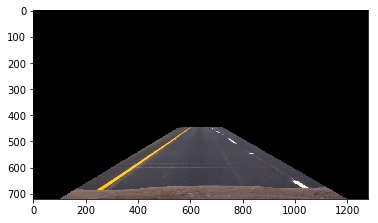

In [13]:
# Image for image shape
img = (mpimg.imread('test_images/straight_lines1.jpg'))
imshape = img.shape

# Four vertices for image masking
vertices = np.array([[(100, imshape[0]),(560, 444),(720,444),(1200, imshape[0])]], dtype = np.int32)

def region_of_interest(img, vertices):
    # Define a blank mask to start with
    mask = np.zeros_like(img)
    
    # Define a 3 or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2] # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # Fill pixels inside the polygon defined by 'vertices' with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    
maskTest = region_of_interest(img, vertices)
plt.imshow(maskTest)

# Test All

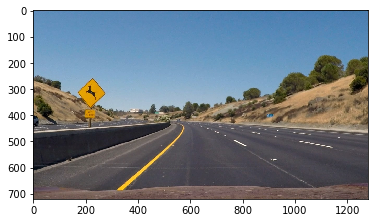

In [14]:
# Test all so far

testAllImg = mpimg.imread('test_images/test2.jpg')
plt.imshow(testAllImg)
plt.savefig('output_images/originalTestImage.jpg')

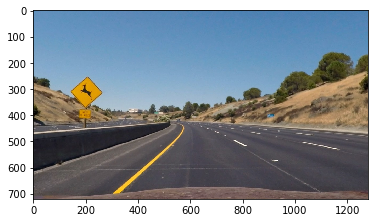

In [15]:
#Undistort
undistorted_testImg, mtx, dist  = cal_undistort(testAllImg, objpoints, imgpoints)
plt.imshow(undistorted_testImg)
plt.savefig('output_images/undistortedlTestImage.jpg')


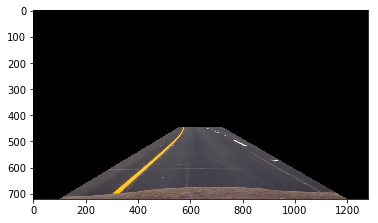

In [16]:
# testing mask

undistorted_masked_test = region_of_interest(undistorted_testImg, vertices)
plt.imshow(undistorted_masked_test)

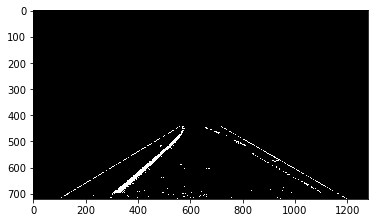

In [17]:
# Color/gradient threshold
thresh_test = threshold(undistorted_masked_test)
plt.imshow(thresh_test, cmap = plt.get_cmap('gray'))
plt.savefig('output_images/undistThreshedTestImage.jpg')



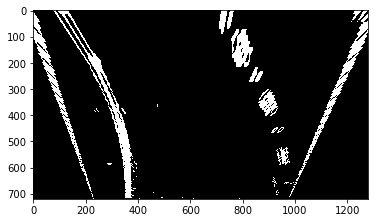

In [18]:
# Perspective Transform
warped_binary_test = warp(thresh_test)
plt.imshow(warped_binary_test, cmap = plt.get_cmap('gray'))
plt.savefig('output_images/undistThreshedTestImage.jpg')

 # Find Lane Lines

In [22]:
def find_lanes(img, undist):
    #  binary image with perspective transform
    binary_warped = img

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ### Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



    # Visualize
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Explicitly defining Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result


# Software Pipeline

In [23]:
def process_img(img):
    undist, mtx, dist  = cal_undistort(img, objpoints, imgpoints)
    threshed = threshold(undist)
    masked = region_of_interest(threshed,vertices)
    warped_binary = warp(masked)
    lanes_found = find_lanes(warped_binary, undist)
    return lanes_found

# Test Pipeline on Images

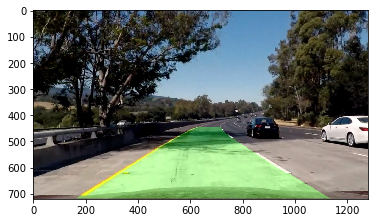

In [24]:
test_image_final = mpimg.imread('test_images/test5.jpg')
test = process_img(test_image_final)
plt.imshow(test)

# Test Pipeline on Videos

In [45]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
output_vid = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_img)
%time output_clip.write_videofile(output_vid, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [39:12<00:01,  1.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

Wall time: 39min 13s


# Display Video in Notebook

In [48]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_vid))

# Test on harder videos

# Trial Code for lane finding function

In [ ]:
image = mpimg.imread('test_images/test2.jpg')
undist, mtx, dist  = cal_undistort(image, objpoints, imgpoints)
threshed = threshold(undist)
warped_binary = warp(threshed)



# Locate lane lines and fit a polynomial

#  binary image with perspective transform
binary_warped = warped_binary

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # # Draw the windows on the visualization image
    # cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
    # cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)



# # Visualize
# #Generate x and y values for plotting
# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
# plt.savefig('output_images/FindingLaneLines_SlidingWindow.jpg')



### Assume you now have a new warped binary image
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



# Visualize
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# # # Draw the lane onto the warped blank image
# cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
# cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)
# plt.savefig('output_images/SkipSlidingWindowStep.jpg')







# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)

# Explicitly defining Minv
Minv = cv2.getPerspectiveTransform(dst, src)

newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
# plt.savefig("output_images/lanefindTest6.jpg")
